# **Bangkit Final Project: World Coin Classification**

# **Dependencies**

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import zipfile

from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import Regularizer, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from google.colab import files

In [0]:
# Upload the kaggle.json file from Kaggle account settings page
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
# Install the Kaggle API client
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup
!chmod 600 ~/.kaggle/kaggle.json

# **Importing Dataset**

In [0]:
# Download the dataset
!kaggle datasets download -d wanderdust/coin-images

 98% 450M/459M [00:08<00:00, 59.8MB/s]
100% 459M/459M [00:09<00:00, 52.7MB/s]


In [0]:
# Unzip the dataset into folder
zip_ref = zipfile.ZipFile('/content/coin-images.zip', 'r')
zip_ref.extractall('/content/')
zip_ref.close()

# **Data Preparation**

In [0]:
# Define directories
data_dir = "/content/coins/data/"

train_dir = data_dir + "train/"
validation_dir = data_dir + "validation/"
test_dir = data_dir + "test/"

In [0]:
# Create generators
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=False,
      featurewise_std_normalization=False,
      samplewise_std_normalization=False,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=False,
      featurewise_std_normalization=False,
      samplewise_std_normalization=False,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(
      rescale=1./255,
      featurewise_std_normalization=False,
      samplewise_std_normalization=False
)

In [0]:
# Read images from generators
batch_size = 32
image_width = 299
image_height = 299

train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(image_width, image_height),
      class_mode="categorical",
      batch_size=batch_size
)

validation_generator = validation_datagen.flow_from_directory(
      validation_dir,
      target_size=(image_width, image_height),
      class_mode="categorical",
      batch_size=batch_size
)

test_generator = test_datagen.flow_from_directory(
      test_dir,
      target_size=(image_width, image_height),
      class_mode="categorical",
      batch_size=1
)

Found 6413 images belonging to 211 classes.
Found 844 images belonging to 211 classes.
Found 844 images belonging to 211 classes.


# **Model**

In [0]:
# Load base model
base_model = Xception(input_shape=(image_width, image_height, 3), weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = True

    # Add regularizer
    l2_layer = l2(0.01)
    if hasattr(layer, 'kernel'):
        base_model.add_loss(lambda layer=layer: l2_layer(layer.kernel))

for layer in base_model.layers[:10]:
		layer.trainable = False

# Custom top classifier for model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(211, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=predictions)

model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_____________________________

In [0]:
# Callback to reduce learning rate if no improvement in validation loss for certain number of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8, verbose=1)

# Callback to stop training if no improvement in validation loss for certain number of epochs
early_stop = EarlyStopping(monitor='val_loss', patience=20)

# Callback to save best model weights per epoch
weights_filepath = "best_model_weights.hdf5"
checkpoint = ModelCheckpoint(
    filepath=weights_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=100,
    steps_per_epoch=50,
    validation_data=validation_generator,
    verbose=1,
    validation_steps=3,
    callbacks=[reduce_lr, checkpoint]
)

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 5.3420 - accuracy: 0.0100
Epoch 00001: val_accuracy improved from -inf to 0.04167, saving model to best_model_weights.hdf5
50/50 [==============================] - 101s 2s/step - loss: 5.3420 - accuracy: 0.0100 - val_loss: 5.3194 - val_accuracy: 0.0417 - lr: 1.0000e-04
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 5.1326 - accuracy: 0.0544
Epoch 00002: val_accuracy improved from 0.04167 to 0.08333, saving model to best_model_weights.hdf5
50/50 [==============================] - 101s 2s/step - loss: 5.1326 - accuracy: 0.0544 - val_loss: 5.1684 - val_accuracy: 0.0833 - lr: 1.0000e-04
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 4.7339 - accuracy: 0.1369
Epoch 00003: val_accuracy improved from 0.08333 to 0.16667, saving model to best_model_weights.hdf5
50/50 [==============================] - 101s 2s/step - loss: 4.7339 - accuracy: 0.1369 - val_loss: 4.5624 - val_accuracy: 0

In [0]:
# Load best model weights
model.load_weights(weights_filepath)

# Save model
model.save("xception_model.h5")

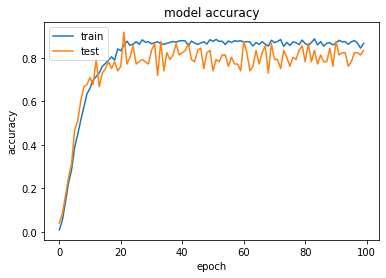

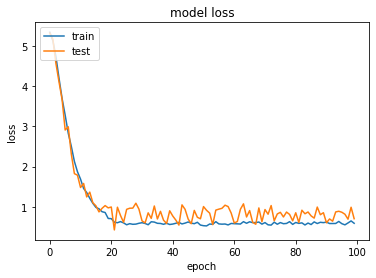

In [0]:
# Visualise accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Visualise loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Evaluate model
train_score = model.evaluate(train_generator, verbose=1)
print("Training loss: ", train_score[0])
print("Training accuracy: ", train_score[1])

test_score = model.evaluate(test_generator, verbose=1)
print("Testing loss: ", test_score[0])
print("Testing accuracy: ", test_score[1])

201/201 [==============================] - 194s 966ms/step - loss: 0.3785 - accuracy: 0.9161
Training loss:  0.3785020709037781
Training accuracy:  0.9161078929901123
844/844 [==============================] - 26s 31ms/step - loss: 0.6999 - accuracy: 0.8389
Testing loss:  0.6998926401138306
Testing accuracy:  0.8388625383377075


In [0]:
# Predict test images
predictions = []

for filename in test_generator.filenames:
    img = load_img(test_dir+filename, target_size=(image_width, image_height))
    img = img_to_array(img)/255
    img_expand = np.expand_dims(img, axis=0)
    predictions.append(model.predict(img_expand)[0])

In [0]:
# Get index of largest probability
predicted_indices = np.argmax(predictions, axis=1)

# Get coin directory name from index 
directories = dict((v, k) for k, v in train_generator.class_indices.items())
predicted_dir = [directories.get(k) for k in predicted_indices]

# Get label name from coin directory name
with open(data_dir + 'cat_to_name.json', 'r') as json_file:
    labels = json.load(json_file)
predicted_labels = [labels.get(str(k)) for k in predicted_dir]

In [0]:
# Save predicted labels as CSV file
filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames, "Predictions": predicted_labels})
results.to_csv("xception_results.csv", index=False)
results.head()

,Filename,Predictions
0,1/021__1 Cent_australia.jpg,"1 Cent,Australian dollar,australia"
1,1/022__1 Cent_australia.jpg,"1 Cent,Australian dollar,australia"
2,1/027__1 Cent_australia.jpg,"1 Cent,Australian dollar,australia"
3,1/036__1 Cent_australia.jpg,"1 Cent,Australian dollar,australia"
4,10/005__5 Centavos_brazil.jpg,"5 Centavos,Brazilian Real,brazil"


# **Convert to TFLite**

In [0]:
# Create converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]

# Convert the model
tflite_model = converter.convert()
open("xception_model.tflite", "wb").write(tflite_model)

87790352